In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install torchxrayvision

In [ ]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv
import os

In [ ]:
model = xrv.baseline_models.chestx_det.PSPNet()

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/pspnet_chestxray_best_model_4.pth -O /root/.torchxrayvision/models_data/pspnet_chestxray_best_model_4.pth`
[██████████████████████████████████████████████████]


In [ ]:
model #I used torchxrayvision PSPNET segmentation model for the localizing the Chest parts of the X-ray images.
      #Unfortunately, I'm not able to provide code of the segmentetaion part because of privacy.

chestx-det-pspnet

In [ ]:
#HISTOGRAM EQUALIZATION

import cv2
input_folder = "/content/train-NORMAL/NORMAL"

output_path = "train-NORMAL-son"

if not os.path.exists(output_path):
  os.makedirs(output_path)


for filename in os.listdir(input_folder):

    file_path = os.path.join(input_folder, filename)


    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)


    img_equalized = cv2.equalizeHist(img)


    output_folder = os.path.join(output_path, filename)
    cv2.imwrite(output_folder, img_equalized)




In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, AveragePooling2D
from tensorflow.keras.layers import ReLU, Flatten, Dense,Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from matplotlib.colors import ListedColormap
from keras.callbacks import ModelCheckpoint
import keras
import sklearn.metrics.pairwise
import sklearn as sk
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib as mpl
import os
import scipy.io
import cv2

# GRAD-CAM

In [ ]:


def get_img_arr(img_path,size):


 img = keras.utils.load_img(img_path, target_size=size)


 array = keras.utils.img_to_array(img)


 array = np.expand_dims(array, axis=0)


 return array

In [ ]:
def gradcam_heatmap(img_array,model, last_conv_layer_name, pred_index=None):


 last_conv_layer = model.get_layer(last_conv_layer_name)

 grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

 with tf.GradientTape() as tape:
  last_layer_conv_outputs, preds = grad_model(img_array)
  if pred_index is None:
    pred_index = tf.argmax(preds[0])
  class_channel = preds[:, pred_index]

 grads = tape.gradient(class_channel, last_layer_conv_outputs)

 pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

 last_layer_conv_outputs = last_layer_conv_outputs[0]
 heatmap = last_layer_conv_outputs @ pooled_grads[..., tf.newaxis]

 heatmap = tf.squeeze(heatmap)

 heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
 return heatmap.numpy()

# DATASET AND MODEL

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=30,
                                   brightness_range=[0.8,1.5],
                                   zoom_range = 0.25,
                                   preprocessing_function= keras.applications.vgg19.preprocess_input,
                                   fill_mode='constant'
                                   )
train_generator1 = train_datagen.flow_from_directory(
    directory="/content/dataset/train",
    target_size=(224,224),
    batch_size=32,
    seed = 6,
    class_mode="binary",
    shuffle=True,
    subset="training"
)


test_datagen = ImageDataGenerator(preprocessing_function= keras.applications.vgg19.preprocess_input

                                 )

test_generator1 = test_datagen.flow_from_directory(
    directory="/content/dataset/test",
    target_size=(224,224),
    batch_size=32,
    seed=6,
    class_mode="binary",
    shuffle=True
)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
new_input = Input(shape=(224, 224, 3))
model1 = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=new_input)


for layer in model1.layers[1:]:
  layer.trainable=True


flat1 = keras.layers.Flatten()(model1.layers[-1].output)


x = Dense(256, activation='relu')(flat1)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=model1.inputs, outputs=output)
keras.utils.plot_model(model1, show_shapes=True, show_trainable=True)
model2.summary()



80134624/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
model2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.TruePositives(thresholds=0.5),
             tf.keras.metrics.TrueNegatives(thresholds=0.5),
             tf.keras.metrics.FalseNegatives(thresholds=0.5),
             tf.keras.metrics.FalsePositives(thresholds=0.5),
             tf.keras.metrics.F1Score()
           ]
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [early_stopping]
history = model2.fit(
    train_generator1,
    shuffle = True,
    batch_size=32,

    epochs=20,
    verbose = 1
)

Epoch 1/20
163/163 [==============================] - 120s 627ms/step - loss: 1.0782 - accuracy: 0.6449 - true_positives: 2980.0000 - true_negatives: 384.0000 - false_negatives: 895.0000 - false_positives: 957.0000 - f1_score: 0.8515
Epoch 2/20
163/163 [==============================] - 100s 612ms/step - loss: 0.4775 - accuracy: 0.7512 - true_positives: 3544.0000 - true_negatives: 374.0000 - false_negatives: 331.0000 - false_positives: 967.0000 - f1_score: 0.8525
Epoch 3/20
163/163 [==============================] - 101s 619ms/step - loss: 0.3510 - accuracy: 0.8313 - true_positives: 3531.0000 - true_negatives: 805.0000 - false_negatives: 344.0000 - false_positives: 536.0000 - f1_score: 0.8525
Epoch 4/20
163/163 [==============================] - 98s 601ms/step - loss: 0.3256 - accuracy: 0.8512 - true_positives: 3475.0000 - true_negatives: 965.0000 - false_negatives: 400.0000 - false_positives: 376.0000 - f1_score: 0.8525
Epoch 5/20
163/163 [==============================] - 99s 606ms/s

# MODEL COMPILING AND TESTING

In [ ]:
result = model2.evaluate(test_generator1,verbose='auto',batch_size=32)

print(result)

20/20 [==============================] - 5s 243ms/step - loss: 0.1665 - accuracy: 0.9391 - true_positives: 387.0000 - true_negatives: 199.0000 - false_negatives: 3.0000 - false_positives: 35.0000 - f1_score: 0.7692
[0.16647474467754364, 0.9391025900840759, 387.0, 199.0, 3.0, 35.0, array([0.7692308], dtype=float32)]


# GRAD-CAM HEATMAP AND VISUALIZING

(1, 224, 224, 3)
1/1 [==============================] - 0s 126ms/step
Predicted class: NORMAL


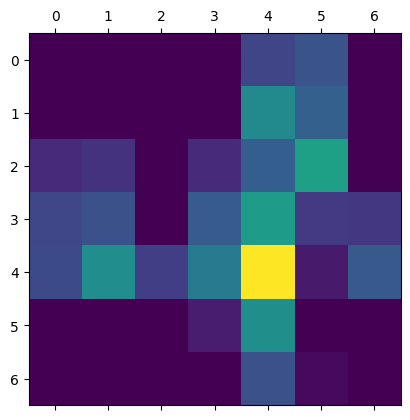

In [ ]:

img_size = (224, 224)
preprocess_input = keras.applications.efficientnet.preprocess_input


last_conv_layer_name = "top_activation"


img_path = "/content/dataset/test/NORMAL/NORMAL2-IM-0221-0001.png"



img_array = preprocess_input(get_img_arr(img_path, size=img_size))
print(img_array.shape)
model = model1

model.layers[-1].activation = None

class_label = ['NORMAL','PNEUMONIA']

preds = model.predict(img_array)

predicted_class_index = np.argmax(preds[0]) #üstteki pred_index=None olmalı.
predicted_class_label = class_label[predicted_class_index]



print("Predicted class:", predicted_class_label)

heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    jet = mpl.colormaps['jet']

    heatmap = np.uint8(255 * heatmap)

    jet_color = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_color[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    print(img.shape)
    print(jet_heatmap.shape)
    birlesmis_img = jet_heatmap * alpha + img
    birlesmis_img = keras.utils.array_to_img(birlesmis_img)

    birlesmis_img.save("cam.jpg")


    birlesmis_img = keras.utils.load_img(cam_path)
    birlesmis_img = keras.utils.img_to_array(birlesmis_img)


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img / 255)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(birlesmis_img / 255)
    axes[1].set_title('Grad-CAM Image')
    axes[1].axis('off')
    plt.show()

save_and_display_gradcam(img_path, heatmap)

# MODEL GRAPHS